# "Puck This" or "Goin' for the stat trick" or "Stats gonna leave a mark"

## A cross-checking of historical hockey data to predict future success using machine learning and neural networks.

##### Team Members: Dave Kingsley, Erin Lampa, Ricky Ravin, Justin Miller & Katie Wright

In [1]:
# Dependencies 

%matplotlib inline
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import glob
import seaborn as sns
from sklearn.svm import SVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## We imported and merged 10 years worth of season team data with the exception of 2013 which was a partial season due to the lockout.

In [2]:
# Read the csv file into a pandas DataFrame

season = pd.concat([pd.read_csv(f) for f in glob.glob('nhl_season_data/*.csv')], 
                             ignore_index = True)

season.head(10)

,Rk,Team,AvAge,GP,W,L,OL,PTS,PTS%,GF,...,PK%,SH,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,SO
0,1,San Jose Sharks*,28.7,82,53,18,11,117,0.713,251,...,83.22,12,11,12.8,14.1,2720,9.2,2228,0.911,9
1,2,Boston Bruins*,28.4,82,53,19,10,116,0.707,270,...,82.35,8,7,12.5,12.8,2482,10.9,2524,0.925,7
2,3,Detroit Red Wings*,31.2,82,51,21,10,112,0.683,289,...,78.29,6,4,10.0,10.9,2965,9.7,2274,0.894,8
3,4,Washington Capitals*,27.2,82,50,24,8,108,0.659,268,...,80.62,7,11,12.7,11.4,2747,9.8,2418,0.901,2
4,5,New Jersey Devils*,30.3,82,51,27,4,106,0.646,238,...,79.94,12,4,12.9,13.1,2698,8.8,2415,0.914,7
5,6,Chicago Blackhawks*,25.9,82,46,24,12,104,0.634,260,...,80.61,10,6,14.1,15.2,2683,9.7,2344,0.911,6
6,7,Vancouver Canucks*,27.9,82,45,27,10,100,0.610,243,...,81.40,7,5,16.5,16.3,2335,10.4,2392,0.911,10
7,8,Pittsburgh Penguins*,26.6,82,45,28,9,99,0.604,258,...,82.71,7,13,13.6,14.2,2381,10.8,2484,0.906,4
8,9,Philadelphia Flyers*,27.0,82,44,27,11,99,0.604,260,...,82.95,16,1,17.5,14.8,2441,10.7,2668,0.913,3
9,10,Calgary Flames*,28.9,82,46,30,6,98,0.598,251,...,83.38,6,15,15.8,15.6,2643,9.5,2441,0.899,4


In [3]:
# Drop Team column

season_clean = season.drop(columns='Team')

In [4]:
# Determine if any columns have null values that need to be removed
# also helps determine column names

season_clean.isnull().sum()

Rk        0
AvAge     0
GP        0
W         0
L         0
OL        0
PTS       0
PTS%      0
GF        0
GA        0
SOW       0
SOL       0
SRS       0
SOS       0
TG/G      0
EVGF      0
EVGA      0
PP        0
PPO       0
PP%       0
PPA       0
PPOA      0
PK%       0
SH        0
SHA       0
PIM/G     0
oPIM/G    0
S         0
S%        0
SA        0
SV%       0
SO        0
dtype: int64

In [5]:
# Determine max of points column to determine appropriate bins

season_clean['PTS'].describe()

count    301.000000
mean      91.667774
std       13.689263
min       48.000000
25%       82.000000
50%       93.000000
75%      101.000000
max      128.000000
Name: PTS, dtype: float64

#### Bins were created to separate the data into teams that were playoff bound and those were not.  Based on the assumption that teams with ~95 points will go to the playoffs (based on information from cbssports.com). .unique() is used to verify the bin value (0) assigned to no_playoffs is less than the value (1) assigned to playoffs before modeling.

In [6]:
# Preprocessing the data: creating appropriate bins to separate out the PTS column into
# "good/playoff" qualifying points and "bad/non-playoff" points.

bins = (47, 94.5, 128)
group_names = ['no_playoffs', 'playoffs']
season_clean['PTS'] = pd.cut(season['PTS'], bins = bins, labels = group_names)
season_clean['PTS'].unique()

[playoffs, no_playoffs]
Categories (2, object): [no_playoffs < playoffs]

In [7]:
# Use LabelEncoder to assign new values to the PTS column

label_quality = LabelEncoder()

In [8]:
# Fit_transform the PTS column using newly encoded values

season_clean['PTS'] = label_quality.fit_transform(season_clean['PTS'])

In [9]:
# Dataframe displaying the newly transformed PTS column

season_clean.head(20)

,Rk,AvAge,GP,W,L,OL,PTS,PTS%,GF,GA,...,PK%,SH,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,SO
0,1,28.7,82,53,18,11,1,0.713,251,199,...,83.22,12,11,12.8,14.1,2720,9.2,2228,0.911,9
1,2,28.4,82,53,19,10,1,0.707,270,190,...,82.35,8,7,12.5,12.8,2482,10.9,2524,0.925,7
2,3,31.2,82,51,21,10,1,0.683,289,240,...,78.29,6,4,10.0,10.9,2965,9.7,2274,0.894,8
3,4,27.2,82,50,24,8,1,0.659,268,240,...,80.62,7,11,12.7,11.4,2747,9.8,2418,0.901,2
4,5,30.3,82,51,27,4,1,0.646,238,207,...,79.94,12,4,12.9,13.1,2698,8.8,2415,0.914,7
5,6,25.9,82,46,24,12,1,0.634,260,209,...,80.61,10,6,14.1,15.2,2683,9.7,2344,0.911,6
6,7,27.9,82,45,27,10,1,0.610,243,213,...,81.40,7,5,16.5,16.3,2335,10.4,2392,0.911,10
7,8,26.6,82,45,28,9,1,0.604,258,233,...,82.71,7,13,13.6,14.2,2381,10.8,2484,0.906,4
8,9,27.0,82,44,27,11,1,0.604,260,232,...,82.95,16,1,17.5,14.8,2441,10.7,2668,0.913,3
9,10,28.9,82,46,30,6,1,0.598,251,246,...,83.38,6,15,15.8,15.6,2643,9.5,2441,0.899,4


In [10]:
# Count the values in each points category (non-playoff and playoff)

season_clean['PTS'].value_counts()

0    164
1    137
Name: PTS, dtype: int64

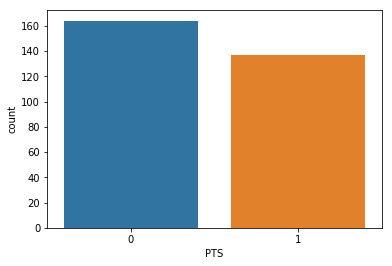

In [11]:
# Visualize the transformed points column distribution 
# using seaborn & matplotlib

sns.countplot(season_clean['PTS'])

In [12]:
# Assign the data to X and y, x predicts y

X = season_clean.drop('PTS', axis = 1)
y = season_clean["PTS"]


In [13]:
# Use train_test_split to create training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [14]:
# Applying standard scaling to get optimized result and reduce large discrepancies
# between the data in each column.

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [15]:
# Visualize the scaled data created for X_train

X_train[:10]

array([[-1.17308356e+00,  3.74733692e-01,  0.00000000e+00,
         1.07373504e+00, -9.29119312e-01, -5.59633071e-01,
         1.01886507e+00,  1.42551373e+00, -8.36716338e-01,
        -8.28020971e-01, -1.25502917e+00,  1.40100143e+00,
        -1.94995056e+00,  4.81924576e-01,  2.11564730e+00,
        -7.33334007e-02, -4.44115167e-01, -1.39556293e+00,
         8.53475784e-01, -1.34882964e+00, -1.48717177e+00,
         5.23566145e-01, -5.84267204e-01, -1.22311229e+00,
        -1.18418205e+00, -1.19261328e+00,  3.24645235e-01,
         1.52691512e+00, -6.15440645e-02,  9.03994816e-01,
        -1.11223333e-01],
       [-2.71124576e-01, -1.14895569e+00,  0.00000000e+00,
         8.01575280e-01, -5.08820028e-02, -2.01053362e+00,
         4.53140717e-01,  1.15000687e+00,  1.77543827e-01,
        -1.25212927e+00, -1.69575848e+00,  6.87548142e-01,
        -2.02129021e-01,  1.03771378e+00,  2.26255106e+00,
         1.44056629e+00, -1.57617343e+00, -1.46857445e+00,
        -1.07769525e+00, -1.96

# Random Forest

#### A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [16]:
# Create Random Forest model

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

In [17]:
# Display the pred_rfc array

pred_rfc[:20]

array([0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1])

In [18]:
# See how well the model performed

print(classification_report(y_test, pred_rfc))
print(confusion_matrix(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        51
           1       1.00      0.97      0.99        40

   micro avg       0.99      0.99      0.99        91
   macro avg       0.99      0.99      0.99        91
weighted avg       0.99      0.99      0.99        91

[[51  0]
 [ 1 39]]


#### A confusion matrix is a table used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. The relative terminology can be confusing but generally it is used to visualize the number of true negatives (51 in our model), false positives (0 in our model), false negatives (1 in our model), and true positives (39 in our model).  So, the random forest model is slightly better at predicting true negatives than true positives but is highly accurate.

In [19]:
# Random Forest Accuracy Score

from sklearn.metrics import accuracy_score
cm = accuracy_score(y_test, pred_rfc)
cm

0.989010989010989

## SVM (Support Vector Machine) Classifier

#### A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples.

#### SVM works better on smaller numbers, random forest does better with binned numbers, SVM is fastest and easiest to apply with mass data.  The difference between the two will eventually go away with mulitple runs.

In [20]:
# Create SVM model

clf=svm.SVC()
clf.fit(X_train, y_train)
pred_clf = clf.predict(X_test)

In [21]:
# See how well the model performed

print(classification_report(y_test, pred_clf))
print(confusion_matrix(y_test, pred_clf))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        51
           1       0.97      0.93      0.95        40

   micro avg       0.96      0.96      0.96        91
   macro avg       0.96      0.95      0.96        91
weighted avg       0.96      0.96      0.96        91

[[50  1]
 [ 3 37]]


In [22]:
# SVM Accuracy Score
svm = accuracy_score(y_test, pred_clf)
svm

0.9560439560439561

## Neural Network

#### Multi-layer Perceptron (MLP) is a supervised learning algorithm that learns a function  by training on a dataset. Given a set of features and a target, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers.

In [23]:
# Use MLPClassifier to create neural network model

mlpc = MLPClassifier(hidden_layer_sizes=(11,11,11), max_iter=500)
mlpc.fit(X_train, y_train)
pred_mlpc = mlpc.predict(X_test)

In [24]:
# See how well the model performed

print(classification_report(y_test, pred_mlpc))
print(confusion_matrix(y_test, pred_mlpc))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        51
           1       0.93      0.93      0.93        40

   micro avg       0.93      0.93      0.93        91
   macro avg       0.93      0.93      0.93        91
weighted avg       0.93      0.93      0.93        91

[[48  3]
 [ 3 37]]


In [25]:
# Neural Network Accuracy Score

nn = accuracy_score(y_test, pred_mlpc)
nn

0.9340659340659341

## Linear Regression Model

#### Linear Regression is a machine learning algorithm based on supervised learning. It performs a regression task. Regression models a target prediction value based on independent variables. It is mostly used for finding out the relationship between variables and forecasting.

In [26]:
# Read the csv file into a pandas DataFrame

season = pd.concat([pd.read_csv(f) for f in glob.glob('nhl_season_data/*.csv')], 
                             ignore_index = True)

season.head(10)

,Rk,Team,AvAge,GP,W,L,OL,PTS,PTS%,GF,...,PK%,SH,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,SO
0,1,San Jose Sharks*,28.7,82,53,18,11,117,0.713,251,...,83.22,12,11,12.8,14.1,2720,9.2,2228,0.911,9
1,2,Boston Bruins*,28.4,82,53,19,10,116,0.707,270,...,82.35,8,7,12.5,12.8,2482,10.9,2524,0.925,7
2,3,Detroit Red Wings*,31.2,82,51,21,10,112,0.683,289,...,78.29,6,4,10.0,10.9,2965,9.7,2274,0.894,8
3,4,Washington Capitals*,27.2,82,50,24,8,108,0.659,268,...,80.62,7,11,12.7,11.4,2747,9.8,2418,0.901,2
4,5,New Jersey Devils*,30.3,82,51,27,4,106,0.646,238,...,79.94,12,4,12.9,13.1,2698,8.8,2415,0.914,7
5,6,Chicago Blackhawks*,25.9,82,46,24,12,104,0.634,260,...,80.61,10,6,14.1,15.2,2683,9.7,2344,0.911,6
6,7,Vancouver Canucks*,27.9,82,45,27,10,100,0.610,243,...,81.40,7,5,16.5,16.3,2335,10.4,2392,0.911,10
7,8,Pittsburgh Penguins*,26.6,82,45,28,9,99,0.604,258,...,82.71,7,13,13.6,14.2,2381,10.8,2484,0.906,4
8,9,Philadelphia Flyers*,27.0,82,44,27,11,99,0.604,260,...,82.95,16,1,17.5,14.8,2441,10.7,2668,0.913,3
9,10,Calgary Flames*,28.9,82,46,30,6,98,0.598,251,...,83.38,6,15,15.8,15.6,2643,9.5,2441,0.899,4


In [27]:
# Drop Team column

season_clean = season.drop(columns='Team')

In [28]:
# Assign the data to X and y, x predicts y

X = season_clean.drop('PTS', axis = 1)
y = season_clean['PTS']

In [29]:
# Use train_test_split to create training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
# Applying standard scaling to get optimized result

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [31]:
# Create the model using LinearRegression

model = LinearRegression()

In [32]:
# Fit the model to the training data and calculate the scores for the training and testing data

model.fit(X_train, y_train)
pred_lrm = model.predict(X_test)

In [33]:
# Determining the features that effect the model the most

model.coef_

array([-3.54235883e-15, -1.77635684e-15,  1.09690035e-13,  6.85129129e+00,
       -7.29422748e+00, -1.86579620e-01,  1.65071775e-13,  2.91729861e-14,
        1.01972352e-13, -3.65656371e-15,  4.21026775e-15,  4.22266433e-14,
       -2.26555886e-15, -8.41973042e-14,  5.20032896e-15, -9.17648224e-15,
       -3.17354302e-16,  1.81799020e-15,  1.11022302e-15, -4.77395901e-15,
       -2.98372438e-16, -7.77156117e-16, -5.55111512e-16, -2.55351296e-15,
        8.74300632e-16, -7.62410968e-16,  1.22124533e-15,  2.22044605e-16,
        1.99840144e-15, -2.99760217e-15, -1.66533454e-15])

#### Indices 3, 4, and 5 have the strongest impact on the model.  These indices correspond to wins, losses and overtime losses respectively.

In [34]:
# Print Training and Test scores

training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 1.0
Testing Score: 1.0


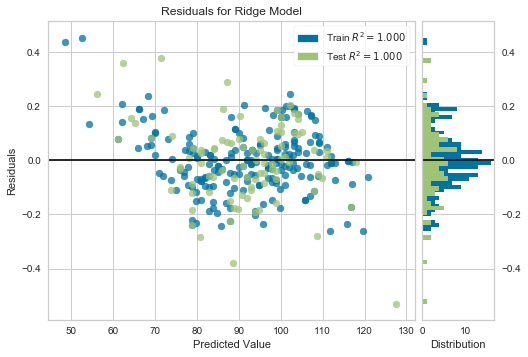

In [35]:
 # Plot the Residuals for Ridge Model
    
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
# Ridge helps prevent over-fitting

ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()                 

In [36]:
# Print mean squared error and R2

from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 2.1082524412060448e-29, R2: 1.0


In [37]:
# Predict the 2016 Wild Score

X_wild = [[17,28,82,38,33,11,0.53,213,204,3,2,0.13,0.01,5.09,158,153,48,259,18.53,45,
           204,77.94,7,6,6.6,8.6,2374,9,2347,0.913,8]]
X_wild = sc.transform(X_wild)
y_wild = model.predict(X_wild)
y_wild

array([87.])

## Linear Regression Using Only Goals For & Against

### We applied train_test_split, StandardScalar, fit_transform to the linear regression model as before with all features.

In [38]:
# Assign the data to X and y, x predicts y

X = season_clean[['GF', 'GA']]
y = season_clean['PTS']

In [39]:
# Use train_test_split to create training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
# Applying standard scaling to get optimized result

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [41]:
# Create the model using LinearRegression

model = LinearRegression()

In [42]:
# Fit the model to the training data and calculate the scores for the training and testing data

model.fit(X_train, y_train)
pred_lrm = model.predict(X_test)

In [43]:
# Determining the features that effect the model the most

model.coef_

array([ 8.69894109, -8.74905836])

In [44]:
# Print Training and Test scores

training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.9113553075585127
Testing Score: 0.8967884572159035


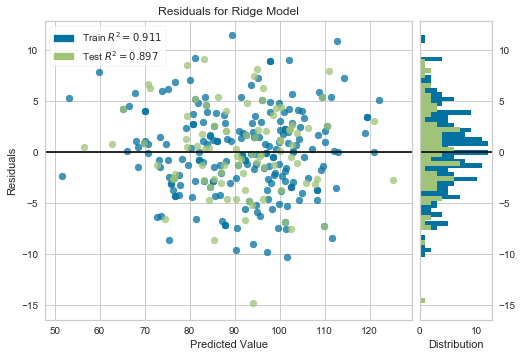

In [45]:
 # Plot the Residuals for Ridge Model
    
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
# Ridge helps prevent over-fitting

ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()  

In [46]:
# Print mean squared error and R2

from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 17.60780693883132, R2: 0.8967884572159035


In [47]:
# Predict the 2016 Wild Score

X_wild = [[213,204]]
X_wild = sc.transform(X_wild)
y_wild = model.predict(X_wild)
y_wild

array([95.07405085])

## Linear Regression Using W, L, OL

In [48]:
# Assign the data to X and y, x predicts y

X = season_clean[['W', 'L', 'OL']]
y = season_clean['PTS']

In [49]:
# Use train_test_split to create training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
# Applying standard scaling to get optimized result

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [51]:
# Create the model using LinearRegression

model = LinearRegression()

In [52]:
# Fit the model to the training data and calculate the scores for the training and testing data

model.fit(X_train, y_train)
pred_lrm = model.predict(X_test)

In [53]:
# Determining the features that effect the model the most

model.coef_

array([ 6.85129129, -7.29422748, -0.18657962])

In [54]:
# Print Training and Test scores

training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 1.0
Testing Score: 1.0


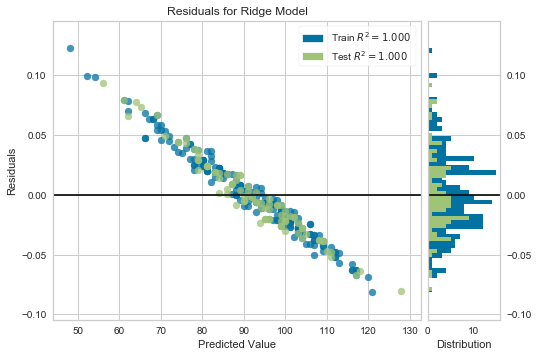

In [55]:
 # Plot the Residuals for Ridge Model
    
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
# Ridge helps prevent over-fitting

ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()  

In [56]:
# Print mean squared error and R2

from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 7.878206490822588e-29, R2: 1.0


In [57]:
# Predict the 2016 Wild Score

X_wild = [[38,33,11]]
X_wild = sc.transform(X_wild)
y_wild = model.predict(X_wild)
y_wild

array([87.])

# Linear Regression Using All Features Except W, L, OTL

### Here we remove wins, losses over time losses from the features to test how accurate the linear regression model is.

In [58]:
# View the dataframe columns to determine features
list(season_clean)

['Rk',
 'AvAge',
 'GP',
 'W',
 'L',
 'OL',
 'PTS',
 'PTS%',
 'GF',
 'GA',
 'SOW',
 'SOL',
 'SRS',
 'SOS',
 'TG/G',
 'EVGF',
 'EVGA',
 'PP',
 'PPO',
 'PP%',
 'PPA',
 'PPOA',
 'PK%',
 'SH',
 'SHA',
 'PIM/G',
 'oPIM/G',
 'S',
 'S%',
 'SA',
 'SV%',
 'SO']

In [59]:
# Assign the data to X and y, x predicts y
# SRS: Simple Rating System, PPA: Power Play Goals Against, PPOA: Power Play, SV%: Save Percentage

X = season_clean[['SOS', 'PPA', 'PPOA', 'SV%']]
y = season_clean['PTS']

In [60]:
# Use train_test_split to create training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [61]:
# Applying standard scaling to get optimized result

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [62]:
# Create the model using LinearRegression

model = LinearRegression()


In [63]:
# Fit the model to the training data and calculate the scores for the training and testing data

model.fit(X_train, y_train)
pred_lrm = model.predict(X_test)

In [64]:
# Determining the features that effect the model the most.

model.coef_

array([-4.57680511, -3.84771811,  2.11631574,  3.73821381])

In [65]:
# Print Training and Test scores

training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.38645601162667576
Testing Score: 0.4540841242646563


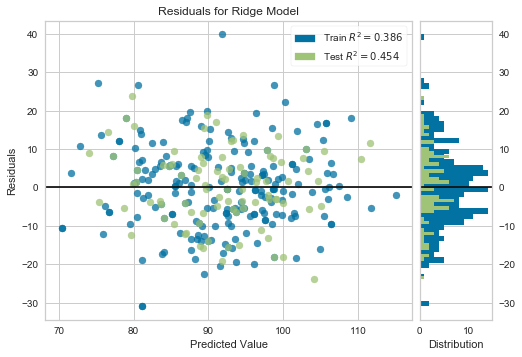

In [66]:
 # Plot the Residuals for Ridge Model
    
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
# Ridge helps prevent over-fitting

ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof() 

In [67]:
# Print values for mean squared error and R2

from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 93.13281330266193, R2: 0.4540841242646563


In [68]:
# Predict the 2016 Wild Score (Actual is 87)

X_wild = [[0.01, 45, 204, 0.913]]
X_wild = sc.transform(X_wild)
y_wild = model.predict(X_wild)
y_wild

array([91.16075534])

In [69]:
# Predict the 2016 Ducks Score (Actual is 103)

X_new = [[-0.05, 37, 290, 0.917]]
X_new = sc.transform(X_new)
y_ducks = model.predict(X_new)
y_ducks

array([106.67180968])

In [70]:
# Predict the 2016 Blue Jackets Score (Actual is 76)

X_new = [[0.03, 53, 279, 0.903]]
X_new = sc.transform(X_new)
y_bluejackets = model.predict(X_new)
y_bluejackets

array([85.38060146])

In [71]:
# Read in 2016 NHL season csv
season_2016 = pd.read_csv('nhl_season_data/2016.csv')

season_2016_clean = season_2016[['SOS', 'PPA', 'PPOA', 'SV%']]
season_2016_clean

,SOS,PPA,PPOA,SV%
0,-0.02,38,256,0.918
1,-0.01,44,248,0.904
2,0.00,41,276,0.919
3,-0.01,40,257,0.918
4,-0.02,55,268,0.917
5,-0.05,37,290,0.917
6,0.00,46,233,0.918
7,-0.04,53,285,0.915
8,0.01,53,243,0.914
9,0.00,36,232,0.915


In [72]:
# Predict 2016 NHL Season Points

X = season_2016_clean
y = season_2016['PTS']

for index, row in X.iterrows():
    X_pred = sc.transform(X)
    y_pred = model.predict(X_pred)
    y_pred
    
print(y_pred)


[101.69790443  91.92513456  99.81644884  99.92908497  96.10254575
 106.67180968  95.59602364  99.00073007  90.80162093  97.58835494
  97.01478711  99.84635816  92.58912946  89.2632362   92.54074792
  94.56416102  91.16075534  88.37535945  86.81267468  93.37797411
  87.6992258   89.95521547  94.64646783  82.82783297  83.9280796
  81.53049125  85.38060146  90.19799061  89.83143736  86.49646568]


In [73]:
team_comparison = pd.DataFrame({'Predicted Scores':y_pred, 'Actual Scores':y})
team_comparison
team_comparison['Score Difference'] = y_pred - y
team_comparison

,Predicted Scores,Actual Scores,Score Difference
0,101.697904,120,-18.302096
1,91.925135,109,-17.074865
2,99.816449,107,-7.183551
3,99.929085,104,-4.070915
4,96.102546,103,-6.897454
5,106.671810,103,3.671810
6,95.596024,103,-7.403976
7,99.000730,102,-2.999270
8,90.801621,101,-10.198379
9,97.588355,100,-2.411645


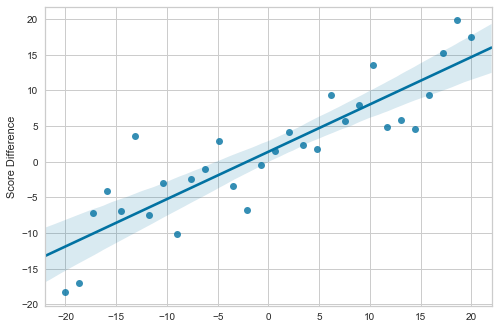

In [106]:
x = np.linspace(-20, 20, 30)
y = team_comparison['Score Difference']

sns.regplot(x,y)

# Now, a look at the player data ...

### We imported and merged 10 years worth of NHL player data.

In [75]:
# Read the csv file into a pandas DataFrame

player = pd.concat([pd.read_csv(f) for f in glob.glob('player_data/*.csv')], 
                             ignore_index = True)

player

,Player,Age,Tm,Pos,GP,G,A,PTS,+/-,PIM,...,EV.1,PP.1,SH.1,S,TOI,ATOI,BLK,HIT,FOW,FOL
0,Spencer Abbott\abbotsp01,28,CHI,LW,1,0,0,0,0,0,...,0,0,0,1,9,8:34,0.0,0,0.0,0.0
1,Justin Abdelkader\abdelju01,29,DET,LW,64,7,14,21,-20,50,...,11,2,1,104,1066,16:40,27.0,144,5.0,12.0
2,Pontus Aberg\abergpo01,23,NSH,LW,15,1,1,2,-2,4,...,1,0,0,12,185,12:20,2.0,9,1.0,0.0
3,Noel Acciari\acciano01,25,BOS,C,29,2,3,5,3,16,...,3,0,0,24,301,10:22,5.0,80,11.0,18.0
4,Kenny Agostino\agostke01,24,STL,LW,7,1,2,3,0,2,...,1,1,0,17,89,12:47,3.0,9,0.0,0.0
5,Sebastian Aho\ahose01,19,CAR,RW,82,24,25,49,-1,26,...,13,11,1,214,1377,16:47,14.0,51,17.0,18.0
6,Karl Alzner\alzneka01,28,WSH,D,82,3,10,13,23,28,...,10,0,0,81,1623,19:47,162.0,105,0.0,0.0
7,Josh Anderson\anderjo05,22,CBJ,RW,78,17,12,29,12,89,...,12,0,0,119,938,12:01,40.0,147,8.0,21.0
8,Rasmus Andersson\anderra01,20,CGY,D,1,0,0,0,-1,0,...,0,0,0,0,19,18:33,2.0,4,0.0,0.0
9,Andy Andreoff\andrean01,25,LAK,LW,36,0,2,2,-2,70,...,2,0,0,38,381,10:36,7.0,70,41.0,28.0


In [76]:
# Drop columns with text values not needed for modeling

cleandf = player.drop(columns = ['Player', 'Tm', 'Pos', 'ATOI'])
cleandf.head()

,Age,GP,G,A,PTS,+/-,PIM,PS,EV,PP,...,GW,EV.1,PP.1,SH.1,S,TOI,BLK,HIT,FOW,FOL
0,28,1,0,0,0,0,0,0.0,0,0,...,0,0,0,0,1,9,0.0,0,0.0,0.0
1,29,64,7,14,21,-20,50,0.7,2,5,...,1,11,2,1,104,1066,27.0,144,5.0,12.0
2,23,15,1,1,2,-2,4,-0.1,1,0,...,0,1,0,0,12,185,2.0,9,1.0,0.0
3,25,29,2,3,5,3,16,0.5,2,0,...,0,3,0,0,24,301,5.0,80,11.0,18.0
4,24,7,1,2,3,0,2,0.3,1,0,...,0,1,1,0,17,89,3.0,9,0.0,0.0


In [77]:
# Determine max of points column to determine appropriate bins

cleandf['PTS'].describe()

count    8845.000000
mean       20.672018
std        20.800314
min         0.000000
25%         3.000000
50%        14.000000
75%        33.000000
max       113.000000
Name: PTS, dtype: float64

In [78]:
# Replace NAN values with the mean

cleandf.fillna(cleandf.mean(), inplace=True)

In [79]:
# Preprocessing the data

bins = (-1, 34.5, 113)
group_names = ['no_playoffs', 'playoffs']
cleandf['PTS'] = pd.cut(cleandf['PTS'], bins = bins, labels = group_names)
cleandf['PTS'].unique()

[no_playoffs, playoffs]
Categories (2, object): [no_playoffs < playoffs]

In [80]:
# Use LabelEncoder to assign new values to the PTS column

label_quality = LabelEncoder()

In [81]:
# Fit_transform the PTS column using newly encoded values

cleandf['PTS'] = label_quality.fit_transform(cleandf['PTS'])

In [82]:
# Dataframe displaying the newly transformed PTS column

cleandf.head(10)

,Age,GP,G,A,PTS,+/-,PIM,PS,EV,PP,...,GW,EV.1,PP.1,SH.1,S,TOI,BLK,HIT,FOW,FOL
0,28,1,0,0,0,0,0,0.0,0,0,...,0,0,0,0,1,9,0.0,0,0.0,0.0
1,29,64,7,14,0,-20,50,0.7,2,5,...,1,11,2,1,104,1066,27.0,144,5.0,12.0
2,23,15,1,1,0,-2,4,-0.1,1,0,...,0,1,0,0,12,185,2.0,9,1.0,0.0
3,25,29,2,3,0,3,16,0.5,2,0,...,0,3,0,0,24,301,5.0,80,11.0,18.0
4,24,7,1,2,0,0,2,0.3,1,0,...,0,1,1,0,17,89,3.0,9,0.0,0.0
5,19,82,24,25,1,-1,26,5.9,17,6,...,4,13,11,1,214,1377,14.0,51,17.0,18.0
6,28,82,3,10,0,23,28,4.6,3,0,...,0,10,0,0,81,1623,162.0,105,0.0,0.0
7,22,78,17,12,0,12,89,4.0,17,0,...,3,12,0,0,119,938,40.0,147,8.0,21.0
8,20,1,0,0,0,-1,0,-0.1,0,0,...,0,0,0,0,0,19,2.0,4,0.0,0.0
9,25,36,0,2,0,-2,70,-0.4,0,0,...,0,2,0,0,38,381,7.0,70,41.0,28.0


In [83]:
# Count the values in each points category (non-playoff and playoff)

cleandf['PTS'].value_counts()

0    6778
1    2067
Name: PTS, dtype: int64

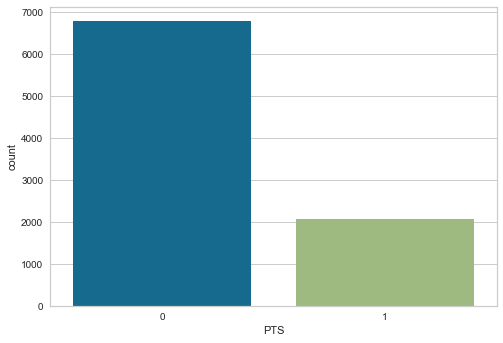

In [84]:
# Visualize the transformed points column distribution 
# using seaborn & matplotlib

sns.countplot(cleandf['PTS'])

In [85]:
# Assign the data to X and y, x predicts y

X = cleandf.drop('PTS', axis = 1)
y = cleandf["PTS"]

In [86]:
# Use train_test_split to create training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [87]:
# Applying standard scaling to get optimized result and reduce large discrepancies
# between the data in each column.

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [88]:
# Visualize the scaled data created for X_train

X_train[:10]

array([[-0.33930397,  0.95918946,  0.48722302, -0.00722265, -1.22472857,
        -0.79078133, -0.30217167,  0.69394534,  0.06180581, -0.35157369,
        -0.69237602,  0.29789816, -0.44398827, -0.41282775,  0.40498043,
         0.53279534,  0.0468289 ,  0.60038186, -0.33336311, -0.34046877],
       [ 1.40776401,  0.16413815, -0.29823878, -0.8423155 , -0.38057481,
         1.76944418, -0.78944449, -0.09909479, -0.5928388 , -0.35157369,
        -0.12791725, -0.86101066, -0.62735928, -0.41282775, -0.40744706,
        -0.63233887, -0.48037988,  0.85034581, -0.39859391, -0.45567106],
       [-1.21283795,  0.78635222,  0.59943185,  0.06869488,  0.25254051,
        -0.59876442,  0.01107515,  1.01116139, -0.26551649, -0.35157369,
         0.43654153,  0.29789816, -0.26061727, -0.41282775,  0.66660962,
         0.13815311, -0.55227199, -0.5601651 , -0.38228621, -0.40959015],
       [-0.33930397,  0.47524518, -0.52265643, -0.53864537, -0.59161325,
         2.28148928, -0.33697687, -0.41631084, -

# Random Forest

In [89]:
# Create Random Forest model

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

In [90]:
# Display the pred_rfc array

pred_rfc[:20]

array([1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0])

In [91]:
# See how well the model performed

print(classification_report(y_test, pred_rfc))
print(confusion_matrix(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2030
           1       0.99      0.99      0.99       624

   micro avg       0.99      0.99      0.99      2654
   macro avg       0.99      0.99      0.99      2654
weighted avg       0.99      0.99      0.99      2654

[[2021    9]
 [   8  616]]


In [92]:
# Random Forest Accuracy Score

from sklearn.metrics import accuracy_score
cm = accuracy_score(y_test, pred_rfc)
cm

0.993594574227581

#### Conclusion: Our model is accurate at predicting player performance using Random Forest.

## SVM (Support Vector Machine) Classifier

In [93]:
from sklearn.svm import SVC
from sklearn import svm

# Create SVM model

clf=svm.SVC()
clf.fit(X_train, y_train)
pred_clf = clf.predict(X_test)

In [94]:
# See how well the model performed

print(classification_report(y_test, pred_clf))
print(confusion_matrix(y_test, pred_clf))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2030
           1       0.97      0.97      0.97       624

   micro avg       0.99      0.99      0.99      2654
   macro avg       0.98      0.98      0.98      2654
weighted avg       0.99      0.99      0.99      2654

[[2012   18]
 [  16  608]]


In [95]:
# SVM Accuracy Score

svm = accuracy_score(y_test, pred_clf)
svm

0.987189148455162

#### Conclusion: SVM is slightly less accurate than Random Forest but still highly accurate.

## Neural Network

In [96]:
# Use MLPClassifier to create neural network model

mlpc = MLPClassifier(hidden_layer_sizes=(11,11,11), max_iter=500)
mlpc.fit(X_train, y_train)
pred_mlpc = mlpc.predict(X_test)

In [97]:
# See how well the model performed

print(classification_report(y_test, pred_mlpc))
print(confusion_matrix(y_test, pred_mlpc))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2030
           1       0.98      0.98      0.98       624

   micro avg       0.99      0.99      0.99      2654
   macro avg       0.99      0.99      0.99      2654
weighted avg       0.99      0.99      0.99      2654

[[2020   10]
 [  11  613]]


In [98]:
# Neural Network Accuracy Score

nn = accuracy_score(y_test, pred_mlpc)
nn

0.9920874152223059

#### All models, including Neural Networks, are highly accurate in predicting a player's points during a season.

In [99]:
########################################

#INSERT LINEAR REGRESSION MODELING HERE!#

########################################